In [1]:
from autoreduce import *
import numpy as np

$ \dot{x} = f(x, \Theta) + g(x)u \\ y = Cx  \\
y = h(x, \Theta)$

In [18]:
# Post conservation law model
n = 2
nouts = 1 # Number of outputs
# Either
# sys.load_SBML_model('my_sbml_model.xml')

# OR write ODEs
#      x = ES, P
#      P = a, d, k, Etot, Stot

# parameter values
P = np.zeros(5)
P[0] = 10
P[1] = 10
P[2] = 0.1
P[3] = 1
P[4] = 1

params_values = P.copy()
timepoints_ode = np.linspace(0, 150, 100) # timepoints for simulation

x_init = np.zeros(n) # Initial conditions

error_tol = 100
nstates_tol = 1
x, f, P = system.load_ODE_model(n, len(params_values))
params = P
f[0] = P[0]*(P[3] - x[0])*(P[4] - x[0] - x[1]) - P[1]*x[0] - P[2]*x[0]
f[1] = P[2]*x[0]
C = np.zeros((nouts,len(x)), dtype=int)
C[0][1] = 1
C = C.tolist()
sys = System(x, f, params = P, params_values = params_values, C = C, x_init = x_init)

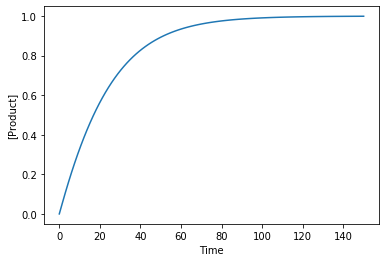

In [19]:
from autoreduce.utils import get_ODE
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
try:
    import matplotlib.pyplot as plt
    plt.plot(timepoints_ode, np.transpose(np.array(C)@sol))
    plt.xlabel('Time')
    plt.ylabel('[Product]')
    plt.show()
except:
    print('Plotting libraries missing.')

In [22]:
from autoreduce.utils import get_SSM
timepoints_ssm = np.linspace(0,60,10)
sys_ssm = get_SSM(sys, timepoints_ssm)
Ss = sys_ssm.compute_SSM(normalize = True) # len(timepoints) x len(params) x len(states)
out_Ss = []
for i in range(len(params)):
    out_Ss.append((np.array(C)@(Ss[:,i,:].T)))
out_Ss = np.reshape(np.array(out_Ss), (len(timepoints_ssm), len(params), nouts))

SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete


c:\users\apand\box\biocircuits\ayush\synbio\autoreduce\autoreduce\local_sensitivity.py:203: RuntimeWarning: divide by zero encountered in true_divide
  SSM_normalized[:,j,i] = np.divide(self.SSM[:,j,i]*self.params_values[j], self.xs[:,i])
c:\users\apand\box\biocircuits\ayush\synbio\autoreduce\autoreduce\local_sensitivity.py:203: RuntimeWarning: invalid value encountered in true_divide
  SSM_normalized[:,j,i] = np.divide(self.SSM[:,j,i]*self.params_values[j], self.xs[:,i])
C:\Users\apand\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in matmul
  import sys


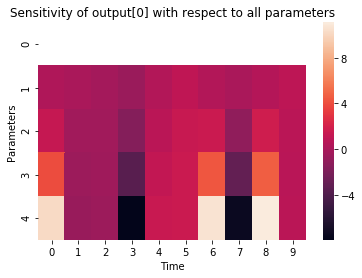

In [23]:
try:
    import seaborn as sn
    for j in range(nouts):
        sn.heatmap(out_Ss[:,:,j].T)
        plt.xlabel('Time')
        plt.ylabel('Parameters')
        plt.title('Sensitivity of output[{0}] with respect to all parameters'.format(j))
        plt.show()
except:
    print('Plotting libraries missing.')

In [24]:
from autoreduce.utils import get_reducible
timepoints_ssm = np.linspace(0,60,10)
timepoints_ode = np.linspace(0, 100, 100)
sys_reduce = get_reducible(sys, timepoints_ode, timepoints_ssm)
results = sys_reduce.reduce_simple()

Successful time-scale separation solution obtained with states: [x1]!
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete
SSM Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [25]:
results

{<autoreduce.system.System at 0x211c88b00f0>: [0.004223827719727595,
  array([  7.44523799,   9.99224283, 168.20771502,   2.74296023,
         127.93239006]),
  1.312256528318756e-05]}

In [30]:
err = results[list(results.keys())[0]][0]
Se = results[list(results.keys())[0]][1]
weighted_se = 0
for p, Se_i in zip(params_values, Se):
    weighted_se += p*Se_i

In [32]:
d_R = weighted_se/err
d_R

76203.61231625082

In [33]:
w1 = 1
w2 = 1e-3
r = w1*err + w2*d_R
r

76.20783614397054

In [8]:
slow_system, fast_system = sys_reduce.solve_timescale_separation([x[1]])
slow_system.f[0]

Successful time-scale separation solution obtained with states: [x1]!


P2*(P0*P3 + P0*P4 - P0*x1 + P1 + P2 - sqrt(P0**2*P3**2 - 2*P0**2*P3*P4 + 2*P0**2*P3*x1 + P0**2*P4**2 - 2*P0**2*P4*x1 + P0**2*x1**2 + 2*P0*P1*P3 + 2*P0*P1*P4 - 2*P0*P1*x1 + 2*P0*P2*P3 + 2*P0*P2*P4 - 2*P0*P2*x1 + P1**2 + 2*P1*P2 + P2**2))/(2*P0)